In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_census = pd.read_csv("/Users/giuliopiccolo/Desktop/lab/project/dataset/NYC_census_2017.csv", index_col=0)
df_blocks = pd.read_csv("/Users/giuliopiccolo/Desktop/lab/project/dataset/NYC_bloc_loc.csv")

In [3]:
print("DataFrame contains", df_census.shape[0], "rows and", df_census.shape[1], "columns.")

DataFrame contains 2167 rows and 35 columns.


In [4]:
print("There are",  df_census.isnull().sum().sum() , "missing values, representing", round(100*df_census.isnull().sum().sum() / (df_census.shape[0]*df_census.shape[1]), 3), "% of the total.")

There are 1269 missing values, representing 1.673 % of the total.


In [5]:
df_census.head()

,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
CensusTract,,,,,,,,,,,,,,,,,,,,,
36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,1.6,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2


To do: try to compute a table like the following one:

![alt text](table_todo.png "Table To Do")

In [7]:
df_blocks.head()

,Latitude,Longitude,BlockCode,County,State
0,40.48,-74.280000,340230076002012,Middlesex,NJ
1,40.48,-74.276834,340230076005000,Middlesex,NJ
2,40.48,-74.273668,340230076003018,Middlesex,NJ
3,40.48,-74.270503,340230076003004,Middlesex,NJ
4,40.48,-74.267337,340230074021000,Middlesex,NJ


We need to merge the two datasets in order to campute a map of CensusBlock. We first need to identify the census tracts associated with our locations. I will use data coordinates in the df_block dataset, but in general, I will use the df_block as a point of reference. 
In order to accomplish my goal, I take the coordinate (df_block) and perform a left join (SQL docet) with df_census values as keys. Since df_census is only for NYC itself, I will filter out everything outside the city. 

In [8]:
df_blocks = df_blocks[df_blocks.County.isin(['Bronx','Kings','New York','Queens','Richmond'])]
df_blocks['Tract'] = df_blocks.BlockCode // 10000
df_blocks = df_blocks.merge(df_census,how='left',right_index=True,left_on='Tract')

df_blocks.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Latitude,Longitude,BlockCode,County_x,State,Tract,County_y,Borough,TotalPop,Men,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
15,40.48,-74.232513,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
16,40.48,-74.229347,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
17,40.48,-74.226181,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
18,40.48,-74.223015,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
19,40.48,-74.219849,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [9]:
#df_blocks.dtypes

In [10]:
# Income is object but should be numeric
df_blocks['Income'] = pd.to_numeric(df_blocks['Income'], errors='coerce')

Converting coordinates to a 2-dimensional array.

Great, we have 2167 rows. All the entries in CensusTract are unique, thus there is no need of cleaning. Let's check also **TotalPop** , **Men** and **Women**.

In [22]:
# Check if there are duplicated in CensusTract column
is_unique = df_blocks.index.tolist()
np.unique(is_unique).size == len(is_unique)

True

In [24]:
# dropping zero entry rows in in Men column
df_blocks = df_blocks[df_blocks.Men != 0]

In [25]:
# dropping zero entry row in Women column
df_blocks = df_blocks[df_blocks.Women != 0]

In [26]:
def convert_to_2d(lats,lons,values):
    lat_min = 40.48
    lon_min = -74.28
    lat_max = 40.93
    lon_max = -73.65
    lon_vals = np.mgrid[lon_min:lon_max:200j]
    lat_vals = np.mgrid[lat_min:lat_max:200j]
    map_values = np.zeros([200,200])
    dlat = lat_vals[1] - lat_vals[0]
    dlon = lon_vals[1] - lon_vals[0]
    for lat,lon,value in zip(lats,lons,values):
        lat_idx = int(np.rint((lat - lat_min) / dlat))
        lon_idx = int(np.rint((lon-lon_min) / dlon ))        
        if not np.isnan(value):
            map_values[lon_idx,lat_idx] = value
    return lat_vals,lon_vals,map_values

Now we can finally plot the matrix with a colorbar.

In [27]:
def make_plot(data_values,title='',colors='Greens'):
    lat_vals,lon_vals,values = convert_to_2d(df_blocks.Latitude,df_blocks.Longitude,data_values)
    fig = plt.figure(1,figsize=[10,10])
    limits = np.min(lon_vals),np.max(lon_vals),np.min(lat_vals),np.max(lat_vals)
    
    im = plt.imshow(values.T,origin='lower',cmap=colors,extent=limits)
    plt.xlabel('Longitude [degrees]')
    plt.ylabel('Latitude [degrees]')
    plt.title(title)
    plt.colorbar(im,fraction=0.035, pad=0.04)
    
    plt.show()

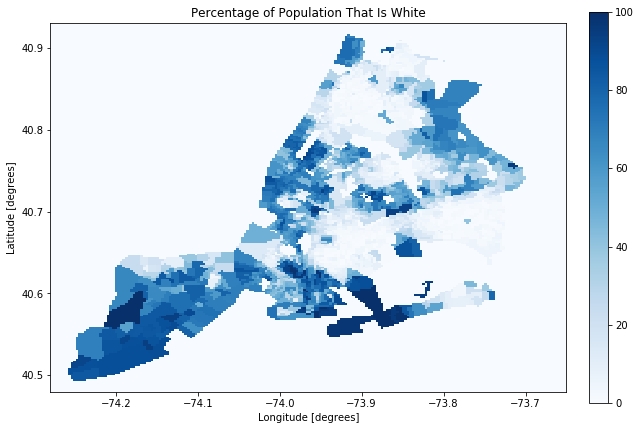

In [28]:
# let's plot White people of White
make_plot(df_blocks.White,colors='Blues',title='Percentage of Population That Is White')

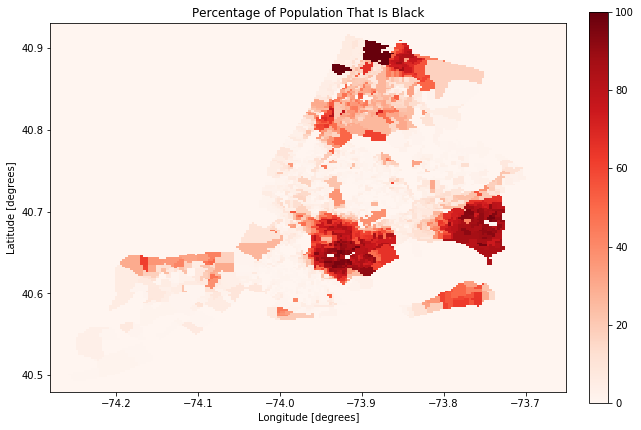

In [29]:
# let's plot Black people of NYC
make_plot(df_blocks.Black,colors='Reds',title='Percentage of Population That Is Black')

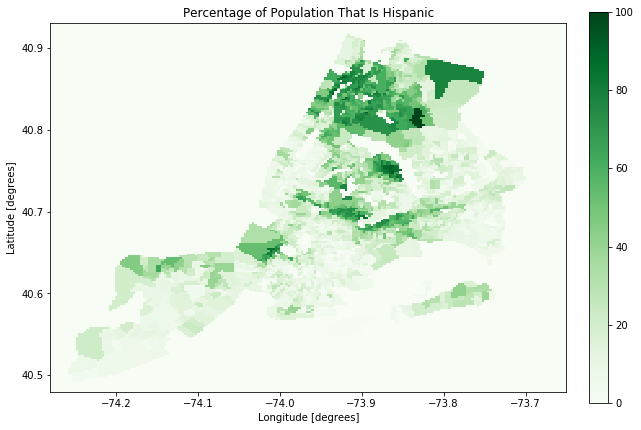

In [30]:
# let's plot Hispanic people of NYC
make_plot(df_blocks.Hispanic,colors='Greens',title='Percentage of Population That Is Hispanic')

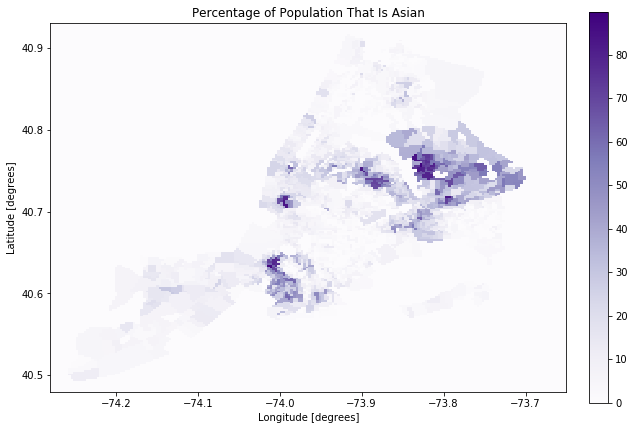

In [31]:
# let's plot Asian people of NYC
make_plot(df_blocks.Asian,colors='Purples',title='Percentage of Population That Is Asian')